In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
PATH = "/content/drive/MyDrive/NLP/"
f = open(PATH + "human_verified_pairs.json",)
data = json.load(f)

print(len(data))
f.close()

In [2]:
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "human_verified_pairs.json",)
data = json.load(f)

print(len(data))
f.close()

778


In [3]:
from sklearn.model_selection import train_test_split

In [ ]:
# train_texts, test_texts = train_test_split(data, test_size= 0.385)
# print(len(test_texts))
# print(len(train_texts))
# with open(PATH + 'data/clean_train.json', 'w') as f:
#   json.dump(train_texts, f)

# with open(PATH + 'data/clearn_test.json', 'w') as f:
#   json.dump(test_texts, f)

300
478


In [11]:
DATAPATH = PATH + 'data/noisy_train.json'
def get_data(path=DATAPATH):

  question_list = list()
  expo_list = list()

  with open(DATAPATH) as f:
    data = list(json.load(f))
  
  for question, expo in data:
    question_list.append(question)
    expo_list.append(expo[0])

  return question_list, expo_list

In [12]:
!pip install datasets
!pip install bert_score

In [ ]:
from datasets import load_metric
metric = load_metric("bertscore")

In [13]:
question_list, expo_list = get_data()

In [14]:
!pip install SentencePiece
!pip install transformers
!pip install pytorch_lightning

In [15]:
import torch
import transformers
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, length):
        self.encodings = encodings
        self.labels = labels
        self.length = length

    def __getitem__(self, idx):
        encoding_item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        label_item = {key: torch.tensor(val[idx]) for key, val in self.labels.items()}
        return encoding_item, label_item

    def __len__(self):
        return self.length

def get_dataset(question_list, expo_list):
    from sklearn.model_selection import train_test_split
    from transformers import T5Tokenizer

    train_qs, val_qs, train_es, val_es = train_test_split(question_list, expo_list, test_size=.1)

    tokenizer = T5Tokenizer.from_pretrained('t5-base')
    print(tokenizer)
    train_q_encodings = tokenizer(train_qs, padding=True, truncation=True)
    val_q_encodings = tokenizer(val_qs, padding=True, truncation=True)

    train_e_encodings = tokenizer(train_es, padding=True, truncation=True)
    val_e_encodings = tokenizer(val_es, padding=True, truncation=True)



    train_dataset = IMDbDataset(train_e_encodings,train_q_encodings, length = len(train_qs))
    val_dataset = IMDbDataset(val_e_encodings, val_q_encodings, length=len(val_qs))

    return train_dataset, val_dataset

In [16]:
train_dataset, val_dataset = get_dataset(question_list, expo_list)

PreTrainedTokenizer(name_or_path='t5-base', vocab_size=32100, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>',

In [17]:
print(len(train_dataset))
print(type(train_dataset))

2835
<class '__main__.IMDbDataset'>


In [23]:
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss

from torch.utils.data import DataLoader
#from transformers import BartForConditionalGeneration, AdamW
#from transformers import RobertaForCausalLM, RobertaConfig, AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-4)

True
cuda


In [24]:
WEIGHT_PATH = PATH + 'weights/noisy_T5'

In [25]:
def train(epochs=10):
    train_loss_set = list()
    for epoch in range(epochs):
        for batch in train_loader:
            input, label = batch
            #print(input)

            optim.zero_grad()

            input_ids = input['input_ids'].to(device)
            attention_mask = input['attention_mask'].to(device)

            labels = label['input_ids'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            # loss_func = BCEWithLogitsLoss()
            # loss = loss_func(logits, labels)  # convert labels to float for calculation
            # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
            train_loss_set.append(loss.item())

            # Backward pass
            loss.backward()

            optim.step()

        print("Finished epoch {}".format(epoch))

    model.save_pretrained(WEIGHT_PATH)
    return train_loss_set

Finished epoch 0
Finished epoch 1
Finished epoch 2
Finished epoch 3
Finished epoch 4
Finished epoch 5
Finished epoch 6
Finished epoch 7
Finished epoch 8
Finished epoch 9


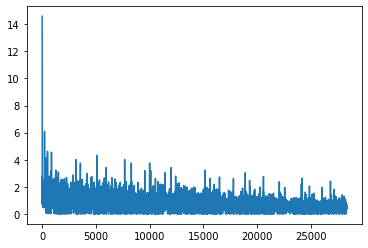

In [26]:
loss_values = train(10)

import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [ ]:
#model = BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)

In [27]:
question_list, expo_list = get_data()
test_dataset = get_dataset(question_list, expo_list)

PreTrainedTokenizer(name_or_path='t5-base', vocab_size=32100, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>',

In [28]:
def get_ppl(encodings, model):
  max_length = 600
  stride = 300

  lls = []
  for i in range(0, encodings.input_ids.size(1), stride):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, encodings.input_ids.size(1))
      trg_len = end_loc - i    # may be different from stride on last loop
      input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
      target_ids = input_ids.clone()
      target_ids[:,:-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          log_likelihood = outputs[0] * trg_len

      lls.append(log_likelihood)

  ppl = torch.exp(torch.stack(lls).sum() / end_loc)
  return ppl

In [29]:
list_of_references, list_of_hypotheses, list_of_original, score, list_of_pp = validate(test_dataset)

NameError: ignored

In [ ]:
print(len(list_of_pp))

300


In [ ]:
print(score)

0.003457070477886912


In [ ]:
sum = ''
print(' '.join(list_of_references[0][0]))

I wanted to revisit China, if I may. And then, I have three separate questions and hopefully, I didn't miss any, thank you on asking these. Firstly, the East China impact on comps, it's obviously a very big market that I think will enter the comp base for the first time in the second quarter of '19. Do you expect that to be a positive or negative as that slug [ph] storage comes in? Secondly, it's been mentioned I think a couple of times, delivery in China is in 2,000 of 3,700 stores approximately or 30 out of 158 cities; so obviously I can understand the major market concentration there but in terms of thinking about percentage of the stores or percentage as the markets to where delivery could make sense based on what you're seeing today. Should we expect China to have a 100% delivery coverage at the end of '19 or '20 or does it make sense for you to have a bigger delivery business in fewer stores?


In [ ]:
print(list_of_references[0])

[['I', 'wanted', 'to', 'revisit', 'China,', 'if', 'I', 'may.', 'And', 'then,', 'I', 'have', 'three', 'separate', 'questions', 'and', 'hopefully,', 'I', "didn't", 'miss', 'any,', 'thank', 'you', 'on', 'asking', 'these.', 'Firstly,', 'the', 'East', 'China', 'impact', 'on', 'comps,', "it's", 'obviously', 'a', 'very', 'big', 'market', 'that', 'I', 'think', 'will', 'enter', 'the', 'comp', 'base', 'for', 'the', 'first', 'time', 'in', 'the', 'second', 'quarter', 'of', "'19.", 'Do', 'you', 'expect', 'that', 'to', 'be', 'a', 'positive', 'or', 'negative', 'as', 'that', 'slug', '[ph]', 'storage', 'comes', 'in?', 'Secondly,', "it's", 'been', 'mentioned', 'I', 'think', 'a', 'couple', 'of', 'times,', 'delivery', 'in', 'China', 'is', 'in', '2,000', 'of', '3,700', 'stores', 'approximately', 'or', '30', 'out', 'of', '158', 'cities;', 'so', 'obviously', 'I', 'can', 'understand', 'the', 'major', 'market', 'concentration', 'there', 'but', 'in', 'terms', 'of', 'thinking', 'about', 'percentage', 'of', 'the'

In [ ]:
print(list_of_pp[2])

tensor(1.7902, device='cuda:0')


In [ ]:
print(list_of_pp[45].item())

2.0658669471740723


In [ ]:
sum = 0
for i in range(len(list_of_pp)):
  sum += list_of_pp[i].item()
  #print(list_of_pp[i])
print(sum/300)

1.9022056953112285


In [ ]:
lis_of_h = []
lis_of_r = []
for i in tqdm(range(len(list_of_hypotheses))):
  print(list_of_hypotheses[i][0])
  h = ' '.join(list_of_hypotheses[i][0])
  print(h)
  #print(list_of_references[i][0])
  r = ' '.join(list_of_references[i][0])
  #print(r)
  lis_of_h.append(h)
  lis_of_r.append(r)

<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >
<pad>
< p a d >



In [ ]:
import bert_score
P, R, F1 = bert_score.score(lis_of_h, lis_of_r, lang='en', verbose=True)


calculating scores...
computing bert embedding.



computing greedy matching.



done in 1.32 seconds, 45.43 sentences/sec


In [ ]:
print(F1)
print(f"System level F1 score: {F1.mean():.3f}")
print(f"System level Precision: {P.mean():.3f}")
print(f"System level Recall: {R.mean():.3f}")

tensor([0.7437, 0.7364, 0.7452, 0.7427, 0.7412, 0.7488, 0.7416, 0.7497, 0.7416,
        0.7330, 0.7503, 0.7404, 0.7400, 0.7435, 0.7527, 0.7515, 0.7423, 0.7470,
        0.7464, 0.7438, 0.7348, 0.7504, 0.7536, 0.7389, 0.7446, 0.7390, 0.7456,
        0.7501, 0.7464, 0.7448, 0.7488, 0.7432, 0.7441, 0.7518, 0.7469, 0.7434,
        0.7480, 0.7579, 0.7493, 0.7475, 0.7390, 0.7389, 0.7449, 0.7355, 0.7453,
        0.7396, 0.7466, 0.7436, 0.7489, 0.7464, 0.7434, 0.7411, 0.7476, 0.7508,
        0.7543, 0.7435, 0.7460, 0.7398, 0.7431, 0.7502])
System level F1 score: 0.745
System level Precision: 0.731
System level Recall: 0.759


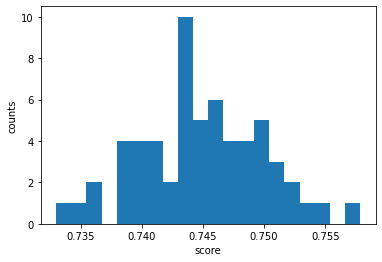

In [ ]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()

In [ ]:
from tqdm.notebook import tqdm
model =  BartForConditionalGeneration.from_pretrained(WEIGHT_PATH)
model.to(device)
generated_sen = []

for i in tqdm(range(0,3441)):
  sentence = data[i][1][0]
  tokenize_input = tokenizer.tokenize(sentence)
  tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)]).to(device)
  a = model.generate(tensor_input,
                do_sample=True,
                max_length=600,
                temperature=1.0,
                top_k=5,
                top_p=0.9,
                repetition_penalty=1.0,
                )
  text = ''
  for w in a:
    text += tokenizer.decode(w, clean_up_tokenization_spaces=True)
  generated_sen.append(text)
  #print(text)
'''
import json
PATH = "/content/drive/MyDrive/Colab Notebooks/NLP/"
f = open(PATH + "generated_sentences.json",'w')
json.dump(generated_sen, f)

f.close()
'''

In [ ]:
print(len(generated_sen))

3441


In [ ]:
print(generated_sen[7])

</s><s>Hi, good morning. Thanks for taking my question. I wanted to follow-up on OptumInsight’s operating margin guidance. So, you’re guiding to about 25% operating margin in fiscal ‘19. You’ve got OptumRx now at 20%, OptumNow at 20%. So, I’m just trying to get a sense of how much of that is coming from Optum insight versus Optum Insight? And then, my second question is just around the Optum business. I think, historically, Optum has been in the mid-single-digit operating margin range for a couple of years, but now, you are moving closer to the upper end of that range. And I was just wondering if you could give us a little bit more color on what you think is driving that relative to your long-term target of 30% to 40% operating margins? Thank you.</s>


In [ ]:
print(list_of_pp)

[tensor(3123.8684, device='cuda:0'), tensor(722.2648, device='cuda:0')]


In [ ]:
print(score)

0.293968634178725


In [ ]:
from pprint import pprint

In [ ]:
for i in range(len(list_of_references)):
  print("Original:")
  print(list_of_original[i])
  print("Ground Truth:")
  print(' '.join(list_of_references[i][0]))
  print("Generated: ")
  print(list_of_hypotheses[i])
  print("-------------------------------")

In [ ]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from tqdm.notebook import tqdm
device = 'cuda:0'
model_id = 'gpt2-large'
gpt_model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

KeyboardInterrupt: ignored

In [ ]:
import math
import torch
!pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import OpenAIGPTTokenizer, OpenAIGPTModel, OpenAIGPTLMHeadModel
# Load pre-trained model (weights)
model = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

     |████████████████████████████████| 133kB 12.0MB/s 
     |████████████████████████████████| 133kB 20.3MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 7.3MB 18.5MB/s 
ERROR: botocore 1.20.35 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


100%|██████████| 458495/458495 [00:00<00:00, 1281637.38B/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [ ]:
def score(sentence):
    tokenize_input = tokenizer.tokenize(sentence)
    tensor_input = torch.tensor([tokenizer.convert_tokens_to_ids(tokenize_input)])
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

a = ["i wrote a book, i wrote a book, i wrote a book, i wrote a book,i wrote a book, i wrote a book.",
   "i wrote a book.",
   "i wrote a book about the life of two young people who fall in love with each other."]
     
print([score(i) for i in a])

TypeError: ignored

In [ ]:
def pp_score(model, sentence,  mask_token_id=103):
  tensor_input = sentence
  repeat_input = tensor_input.repeat(tensor_input.size(-1)-2, 1)
  mask = torch.ones(tensor_input.size(-1) - 1).diag(1)[:-2]
  masked_input = repeat_input.masked_fill(mask == 1, 103)
  labels = repeat_input.masked_fill( masked_input != 103, -100)
  loss,_ = model(masked_input, masked_lm_labels=labels)
  result = np.exp(loss.item())
  return result